In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.special import erf, erfc
from scipy.optimize import brute
from mpl_toolkits.mplot3d import Axes3D
from concurrent.futures import ThreadPoolExecutor
from pandas.plotting import register_matplotlib_converters
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display, clear_output
import time
register_matplotlib_converters()

In [12]:
def black_scholes_option_price(S0, K, r, T, mu, sigma_C, sigma_P, option_type='C'):
    """
    Calculate the Black-Scholes option price for different volatilities for call and put.
    Assume sp500 is distributed: log normal ~ (S0 + mu T, sigma sqrt(T))
    Parameters:
    - S0: Current price of the underlying asset
    - K: Strike price of the option
    - r: Risk-free interest rate (annualized)
    - T: Time to expiration (in years)
    - mu: Drift rate
    - sigma_C: Volatility for call option
    - sigma_P: Volatility for put option
    - option_type: 'C' for call option, 'P' for put option

    Returns:
    - Option price calculated using the Black-Scholes formula
    """
    # Determine which volatility to use based on option type
    sigma = sigma_C if option_type == 'C' else sigma_P
    
    common_term_1 = np.exp(T * mu + (T * sigma**2) / 2) * S0
    common_term_2 = (T * (mu + sigma**2) - np.log(K) + np.log(S0)) / (np.sqrt(2) * np.sqrt(T) * sigma)
    common_term_3 = (T * mu - np.log(K) + np.log(S0)) / (np.sqrt(2) * np.sqrt(T) * sigma)
    discount_factor = 2 * np.exp(-r * T)
    
    if option_type == 'C':
        option_price = (common_term_1 * (1 + erf(common_term_2)) + K * (-2 + erfc(common_term_3))) / discount_factor
    elif option_type == 'P':
        option_price = (K * erfc(common_term_3) - common_term_1 * erfc(common_term_2)) / discount_factor
    else:
        raise ValueError("Invalid option_type. Expected 'C' or 'P' for call or put option respectively.")
    
    return option_price


# Define the compute_implied_sharpe_for_date_global function
def compute_implied_sharpe_for_date_global(chosen_date, options, underlying, risk_free_rate):    # Extract relevant data for the chosen date
    underlying_price = underlying[underlying['date'] == chosen_date]['close'].values[0]
    options_subset = options[options['date'] == chosen_date]
    time_to_expiration = options_subset['tau'].unique()
    closest_expiration = min([tau for tau in time_to_expiration if tau > 30])
    options_closest_expiration = options_subset[options_subset['tau'] == closest_expiration]

    # Subset to OTM options
    otm_calls = options_closest_expiration[(options_closest_expiration['cp_flag'] == 'C') & 
                                           (options_closest_expiration['strike_price']/1000 > underlying_price)]
    otm_puts = options_closest_expiration[(options_closest_expiration['cp_flag'] == 'P') & 
                                          (options_closest_expiration['strike_price']/1000 < underlying_price)]
    call_strikes = otm_calls['strike_price'].values / 1000
    put_strikes = otm_puts['strike_price'].values / 1000

    # Define the observed option prices and types
    observed_prices_calls = (otm_calls['best_bid'] + otm_calls['best_offer']) / 2
    observed_prices_puts = (otm_puts['best_bid'] + otm_puts['best_offer']) / 2
    observed_prices = np.concatenate([observed_prices_calls.values, observed_prices_puts.values])
    observed_strikes = np.concatenate([call_strikes, put_strikes])
    observed_types = ['C' if K > underlying_price else 'P' for K in observed_strikes]

    # Construct the risk-free rate for the chosen expiration using interpolation
    risk_free_rates_subset = risk_free_rate[risk_free_rate['date'] == chosen_date]
    interp_function = interp1d(risk_free_rates_subset['days'], risk_free_rates_subset['rate'], kind='linear', fill_value="extrapolate")
    risk_free_for_expiration = float(interp_function(closest_expiration))

    # Define bounds for mu, sigma_C (for calls), and sigma_P (for puts)
    bounds = [(-0.3, 0.7), (0.01, 1), (0.01, 1)]

    # Perform differential evolution global optimization
    daily_args = (observed_strikes, observed_prices, underlying_price, risk_free_for_expiration, closest_expiration, observed_types)
    result = differential_evolution(loss_function, bounds, args=daily_args)

    best_mu, best_sigma_C, best_sigma_P = result.x  # Optimized parameters
    err = result.fun  

    # Compute the average of the two sigmas for the Sharpe ratio
    sigma_avg = (best_sigma_C + best_sigma_P) / 2

    # Compute the implied Sharpe ratio
    implied_sharpe = (best_mu - risk_free_for_expiration/100) / sigma_avg
    
    results = {
        'best_mu': best_mu,
        'best_sigma_C': best_sigma_C,
        'best_sigma_P': best_sigma_P,
        'sigma_avg': sigma_avg,
        'implied_sharpe': implied_sharpe,
        'err': err,
        'observed_prices_calls': observed_prices_calls,  # Add this line
        'observed_prices_puts': observed_prices_puts,    # Add this line
        'call_strikes': call_strikes,                    # Add this line
        'put_strikes': put_strikes,                      # Add this line
        'observed_strikes': observed_strikes,            # Add this line
        'observed_types': observed_types,                # Add this line
        'closest_expiration': closest_expiration,        # Existing line
        'risk_free_for_expiration': risk_free_for_expiration,
        'underlying_price': underlying_price
    }
        
    return results

# Define the loss function
def loss_function(params, observed_strikes, observed_prices, underlying_price, risk_free_for_expiration, closest_expiration, observed_types):
    mu, sigma_C, sigma_P = params
    theoretical_prices = [black_scholes_option_price(underlying_price, K, risk_free_for_expiration/100, 
                                                     closest_expiration/365, mu, sigma_C, sigma_P, option_type=otype) 
                          for K, otype in zip(observed_strikes, observed_types)]
    theoretical_prices_array = np.array(theoretical_prices)
    if np.any(theoretical_prices_array <= 0):
        return 1e10  # return a large penalty if prices are non-physical
    residuals = (observed_prices - theoretical_prices_array) / observed_prices
    return np.sum(residuals**2)


def compute_implied_sharpe_dataframe(options, underlying, risk_free_rate):
    # Get unique dates from the datasets
    unique_dates = sorted(list(set(options['date'].unique()) & set(underlying['date'].unique()) & set(risk_free_rate['date'].unique())))
    
    # Lists to store results
    dates_list = []
    E_X_list = []
    SD_X_list = []
    implied_sharpe_list = []
    
    # Total number of dates for progress tracking
    total_dates = len(unique_dates)
    
    # Iterate through each date
    for i, chosen_date in enumerate(unique_dates):
        # Compute results for the date
        results = compute_implied_sharpe_for_date_global(chosen_date, options, underlying, risk_free_rate)
        
        # Accessing elements from the results dictionary
        best_mu = results['best_mu']
        best_sigma = results['best_sigma']
        implied_sharpe = results['implied_sharpe']
        err = results['err']
        observed_prices_calls = results['observed_prices_calls']
        observed_prices_puts = results['observed_prices_puts']
        observed_strikes = results['observed_strikes']
        observed_types = results['observed_types']
        risk_free_for_expiration = results['risk_free_for_expiration']
        underlying_price = results['underlying_price']
        put_strikes = results['put_strikes']
        call_strikes = results['call_strikes']
        
        # Append results to lists
        dates_list.append(chosen_date)
        E_X_list.append(mu)
        SD_X_list.append(sigma)
        implied_sharpe_list.append(implied_sharpe)
        
        # Print progress
        print(f"Sharpe: {implied_sharpe} | Processed {i+1}/{total_dates} dates...", end='\r')
      

    
    # Create a dataframe from the results
    result_df = pd.DataFrame({
        'Date': dates_list,
        'mu': mu,
        'sigma': sigma,
        'Implied_Sharpe': implied_sharpe_list
    })
    
    return result_df

def subset_dataframe_by_date(df, start_date, end_date, date_column='date'):
    """
    Subset a dataframe by a date range.

    Parameters:
    - df: The dataframe to subset.
    - start_date: The start of the date range (inclusive).
    - end_date: The end of the date range (inclusive).
    - date_column: The name of the date column in the dataframe. Default is 'date'.

    Returns:
    - A subsetted dataframe.
    """
    mask = (df[date_column] >= start_date) & (df[date_column] <= end_date)
    return df[mask]

def plot_option_prices(dates, options, underlying, risk_free_rate):
    # Pre-compute the results for all dates to avoid redundant computation
    precomputed_results = {date: compute_implied_sharpe_for_date_global(date, options, underlying, risk_free_rate) for date in dates}

    fig, axes = plt.subplots(1, len(dates), figsize=(14 * len(dates), 7))
    if len(dates) == 1:
        axes = [axes]
    
    for idx, chosen_date in enumerate(dates):
        # Retrieve precomputed results for the chosen date
        results = precomputed_results[chosen_date]
        sigma_C = results['best_sigma_C']  # Retrieve sigma_C from the results
        sigma_P = results['best_sigma_P']  # Retrieve sigma_P from the results
        plot_prices_for_date(axes[idx], chosen_date, results, sigma_C, sigma_P)

    plt.tight_layout()
    plt.show()


    
def plot_prices_for_date(ax, chosen_date, results, sigma_C, sigma_P):
    observed_prices_calls = results['observed_prices_calls']
    observed_prices_puts = results['observed_prices_puts']
    observed_strikes = results['observed_strikes']
    observed_types = results['observed_types']
    call_strikes = results['call_strikes']
    put_strikes = results['put_strikes']
    best_mu = results['best_mu']
    risk_free_for_expiration = results['risk_free_for_expiration']
    underlying_price = results['underlying_price']

    # Compute theoretical option prices using the optimized parameters
    theoretical_prices_optimized = [black_scholes_option_price(underlying_price, K, risk_free_for_expiration/100, 
                                                              results['closest_expiration']/365, best_mu, sigma_C, sigma_P, option_type=otype) 
                                   for K, otype in zip(observed_strikes, observed_types)]

    # Plot observed OTM call options in blue and put options in red
    ax.scatter(call_strikes, observed_prices_calls, color='blue', label='Observed Call Prices', alpha=0.6)
    ax.scatter(put_strikes, observed_prices_puts, color='red', label='Observed Put Prices', alpha=0.6)

    # Plot theoretical prices using optimized parameters
    ax.scatter(observed_strikes, theoretical_prices_optimized, color='green', marker='x', label='Theoretical Prices (Optimized Parameters)')

    ax.axvline(x=underlying_price, color='black', linestyle='--', label=f'Underlying Price: {underlying_price:.2f}')
    ax.set_title(f'Option Prices vs. Strike Prices on {chosen_date}\nOptimized Mean (μ): {best_mu:.4f}, Optimized Sigma (σ_C): {sigma_C:.4f}, Optimized Sigma (σ_P): {sigma_P:.4f}')
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Option Price')
    ax.legend()
    ax.grid(True)

def compute_all_dates(options, underlying, risk_free_rate, nworkers):
    # Get unique dates from the datasets
    unique_dates = sorted(list(set(options['date'].unique()) & set(underlying['date'].unique()) & set(risk_free_rate['date'].unique())))

    # Function to execute for each date
    def process_date(chosen_date):
        results = compute_implied_sharpe_for_date_global(chosen_date, options, underlying, risk_free_rate)
        return {
            'Date': chosen_date,
            'Optimized_mu': results['best_mu'],
            'Optimized_sigma_C': results['best_sigma_C'],
            'Optimized_sigma_P': results['best_sigma_P'],
            'Implied_Sharpe': results['implied_sharpe'],
            'Loss_Error': results['err']
        }

    # Use ThreadPoolExecutor to parallelize the computation
    display(f"Starting parallel workers: {nworkers}")
    results_list = []
    with ThreadPoolExecutor(max_workers=nworkers) as executor:  # Adjust the number of workers as needed
        # Submit all the tasks and get their futures
        progress=0
        future_to_date = {executor.submit(process_date, date): date for date in unique_dates}
        for future in as_completed(future_to_date):
            date = future_to_date[future]
            try:
                result = future.result()
                results_list.append(result)
                progress += 1
                clear_output(wait=True)
                display(f"Completed {progress*100/len(unique_dates):.2f}% - {result}")
            except Exception as exc:
                display(f"Date {date} generated an exception: {exc}")

    # Create a dataframe from the results
    result_df = pd.DataFrame(results_list)
    
    # Sort the dataframe by date
    result_df.sort_values('Date', inplace=True)
    
    return result_df

def plot_implied_sharpe_results(result_df):
    # Set the figure size and layout
    plt.figure(figsize=(14, 10))
    result_df['Date'] = pd.to_datetime(result_df['Date'])
    
    # Plot optimized mu
    plt.subplot(2, 2, 1)
    plt.plot(result_df['Date'], result_df['Optimized_mu'], label='Optimized mu (Mean Return)')
    plt.title('Optimized Mean Return Over Time')
    plt.xlabel('Date')
    plt.ylabel('Optimized mu')
    plt.legend()
    
    # Plot optimized sigma
    plt.subplot(2, 2, 2)
    plt.plot(result_df['Date'], result_df['Optimized_sigma_C'], label='Optimized sigma (Volatility)')
    plt.title('Optimized Call Volatility Over Time')
    plt.xlabel('Date')
    plt.ylabel('Optimized sigma')
    plt.legend()
    
    # Plot optimized sigma
    plt.subplot(2, 2, 3)
    plt.plot(result_df['Date'], result_df['Optimized_sigma_P'], label='Optimized sigma (Volatility)')
    plt.title('Optimized Put Volatility Over Time')
    plt.xlabel('Date')
    plt.ylabel('Optimized sigma')
    plt.legend()

    # Plot Implied Sharpe Ratio
    plt.subplot(2, 2, 4)
    plt.plot(result_df['Date'], result_df['Implied_Sharpe'], label='Implied Sharpe Ratio')
    plt.title('Implied Sharpe Ratio Over Time')
    plt.xlabel('Date')
    plt.ylabel('Implied Sharpe Ratio')
    plt.legend()

    # Adjust the x-axis dates to only show the first date of each month
    ax = plt.gca()  # Get the current axis
    
    # Set major and minor locators to show only the first day of each month
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
    plt.tight_layout()  # Adjust layout to prevent overlap
    
    # Display the plot
    plt.show()

In [3]:
# Load data
options = pd.read_csv('sp500_subset.csv', low_memory=False)
underlying = pd.read_csv('U_subset.csv')
risk_free_rate = pd.read_csv('rf_subset.csv')

In [4]:
# Format data

# Convert the 'date' columns in all dataframes to datetime format
options['date'] = pd.to_datetime(options['date'])
underlying['date'] = pd.to_datetime(underlying['date'])
risk_free_rate['date'] = pd.to_datetime(risk_free_rate['date'])

# Get unique dates from each dataframe after formatting
unique_dates_options = set(options['date'].unique())
unique_dates_underlying = set(underlying['date'].unique())
unique_dates_risk_free = set(risk_free_rate['date'].unique())

# Find the intersection of unique dates across the three dataframes
common_dates = unique_dates_options.intersection(unique_dates_underlying).intersection(unique_dates_risk_free)

# Subset each dataframe to the common dates
options = options[options['date'].isin(common_dates)]
underlying= underlying[underlying['date'].isin(common_dates)]
risk_free_rate = risk_free_rate[risk_free_rate['date'].isin(common_dates)]

# Ensure 'date' and 'exdate' columns are in datetime format
options['date'] = pd.to_datetime(options['date'])
options['exdate'] = pd.to_datetime(options['exdate'])

# Re-compute 'tau' as the difference between 'exdate' and 'date' in days
options['tau'] = (options['exdate'] - options['date']).dt.days

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/patrickshultz/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/9t/gvvpp4nx48x0hnl6jtl7j3s00000gn/T/ipykernel_5838/342696506.py", line 2, in <module>
    plot_option_prices([underlying['date'].iloc[1]], options, underlying, risk_free_rate)
  File "/var/folders/9t/gvvpp4nx48x0hnl6jtl7j3s00000gn/T/ipykernel_5838/2815264799.py", line 197, in plot_option_prices
    plt.tight_layout()
  File "/Users/patrickshultz/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py", line 2314, in tight_layout
    return gcf().tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=rect)
  File "/Users/patrickshultz/anaconda3/lib/python3.9/site-packages/matplotlib/figure.py", line 3224, in tight_layout
    kwargs = get_tight_layout_figure(
  File "/Users/patrickshultz/anaconda3/lib/python3.9/site-packages/matplotlib/tight_layout.py", li

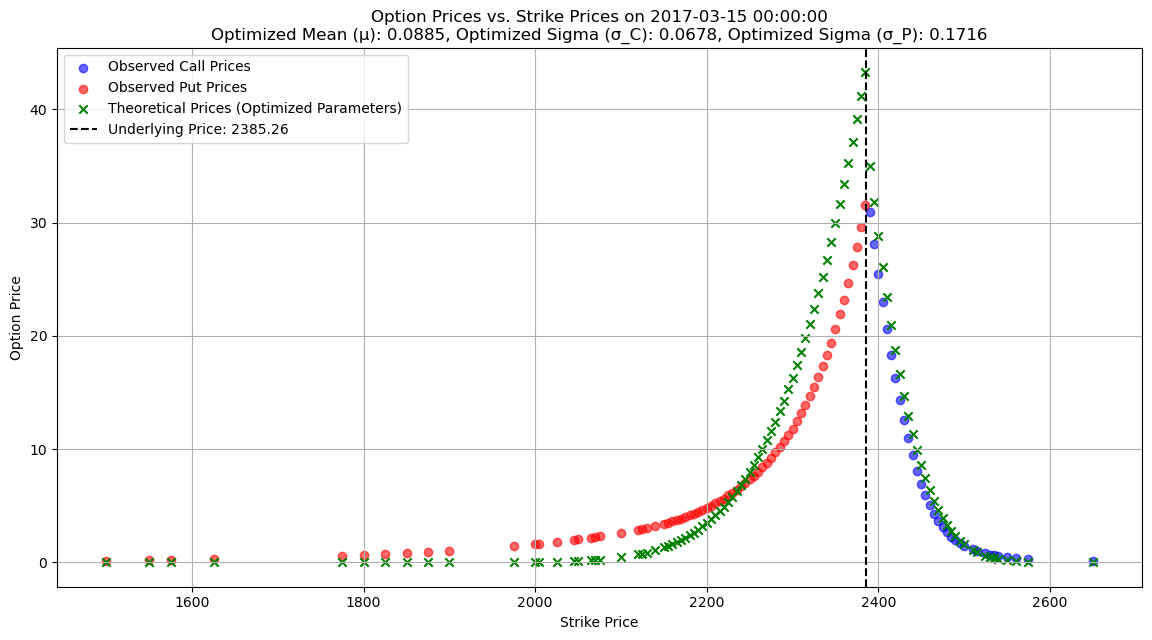

In [ ]:
# test day and plot
plot_option_prices([underlying['date'].iloc[1]], options, underlying, risk_free_rate)

In [15]:
result_df = compute_all_dates(options, underlying, risk_free_rate, 6)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 

In [ ]:
plot_implied_sharpe_results(result_df)